In [1]:
import pennylane as qml 
import pennylane.numpy as pnp 
import numpy as np 
from qas import qml_gate_ops 
from qas import qml_models 
from qas import mcts
import os 
import json 
from pprint import pprint
import matplotlib.pyplot as plt
cwd = os.getcwd() 
print(cwd)

res_file = '20211009-231603.json'
with open(os.path.join(cwd, res_file)) as f:
    res_dict = json.load(f)

print(res_dict.keys())


d:\Research\QAS-Qiskit\QAS
dict_keys(['task', 'pool', 'params', 'k', 'op_list', 'search_reward_list', 'fine_tune_loss'])


In [8]:
pool = {int(k):res_dict['pool'][k] for k in res_dict['pool'].keys()}
params = np.array(res_dict['params'])
#print(params.shape)
#print(res_dict['k'])
#print(pool)
model = qml_models.ToffoliQMLNoiseless(params.shape[0], params.shape[1], params.shape[2], res_dict['k'], pool)
#print(model.toList(params))
search_rewards = [s[2] for s in res_dict['search_reward_list']]
print(search_rewards)
fine_tune_loss_after_search = res_dict['fine_tune_loss']
print(fine_tune_loss_after_search)

[0.6353290709750954, 0.746336354246353, 0.5237699009662575, 0.7023524868712564, 0.7390591029784208, 0.7524781089701117, 0.9209153407786593]
[0.07908465922134067, 0.0745160370800797, 0.07128501737323245, 0.06863875497790806, 0.06633485674826745, 0.06425299680486696, 0.06232632412720285, 0.06051702142906501, 0.05880074581774419, 0.057159323870882295, 0.055578315643118104, 0.05404774116276989, 0.0525620689816676, 0.051118375909873226, 0.049714516186082025, 0.04834829114192485, 0.047017899753907244, 0.045722710257839916, 0.04446307675799077, 0.043239445733824544, 0.04205164435779596, 0.04089891471483331, 0.039780529883000626, 0.038696128114100725, 0.03764538360366432, 0.03662749511555863, 0.035641088836855794, 0.034684651194929916, 0.03375695897840958, 0.032857025469983814, 0.031983762258462445, 0.031135860515864144, 0.030312073410165397, 0.02951153405208551, 0.028733706076994103, 0.027978088891784214, 0.02724408801605216, 0.026531186636186144, 0.02583911318904608, 0.025167727093616032, 0.

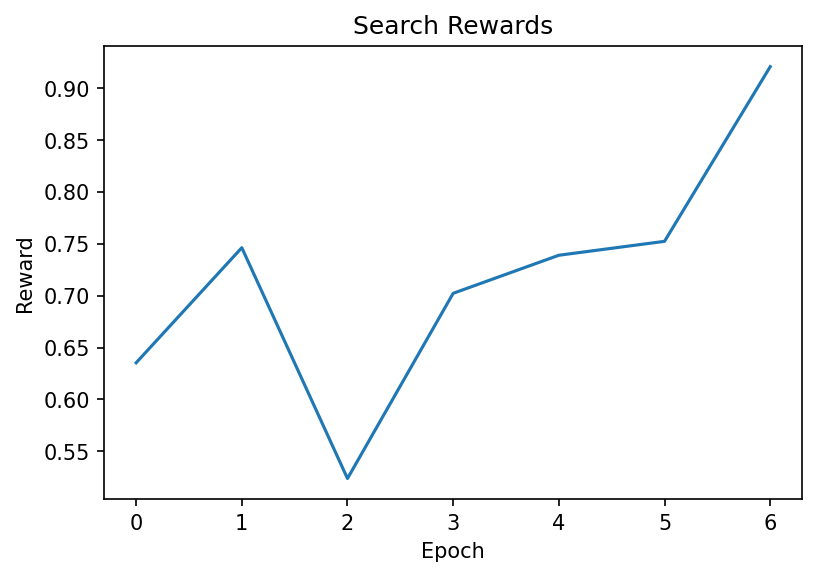

In [11]:
plt.figure(dpi=150)
plt.plot(list(range(len(search_rewards))), search_rewards)
plt.title("Search Rewards")
plt.xlabel('Epoch')
plt.ylabel('Reward')

plt.show()

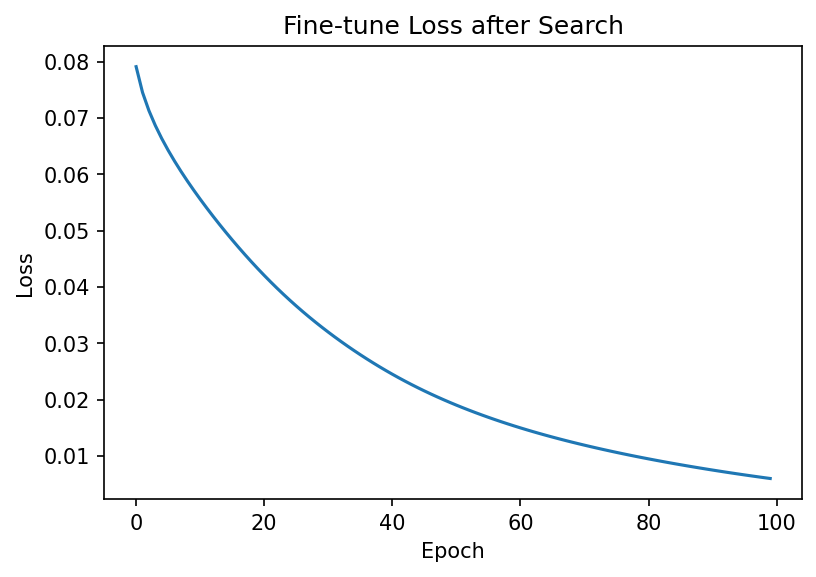

In [12]:
plt.figure(dpi=150)
plt.plot(list(range(len(fine_tune_loss_after_search))), fine_tune_loss_after_search)
plt.title("Fine-tune Loss after Search")
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.show()

In [13]:
dev = qml.device('default.qubit', wires = 3)
@qml.qnode(dev)
def searched_circ(x):
    qml.QubitStateVector(x, wires=[0,1,2])
    qml.CNOT(wires =[0,2])
    qml.CRot(1.129680337296492, 1.5707922440908313, -0.0008633026512832973, wires=[1,2])
    qml.CNOT(wires =[0,2])
    qml.CRot(0.026147067452042146, -1.26553346484485, 0.8799594504776643, wires=[1,2])
    qml.Rot(-0.7463000265359258, 0.000728433748695468, 0.7427270846724496, wires = 1)
    qml.Rot(-0.7774424770311453, 0.0006764088145414327, -0.3979643430853004, wires = 0)
    qml.Rot(-0.942913291994291, -0.1571363759045717, 0.6860885220354251, wires = 2)
    return qml.state()

@qml.qnode(dev)
def target_circ(x):
    qml.QubitStateVector(x, wires=[0,1,2])
    qml.Toffoli(wires=[0,1,2])
    return qml.state()

computational_bases = {"0":np.array([1,0]), "1":np.array([0,1])}

In [14]:
print(qml.draw(searched_circ)(np.kron(computational_bases['1'], np.kron(computational_bases['1'], computational_bases['0']))))

 0: ──╭QubitStateVector(M0)──╭C───────────────────────────────╭C───Rot(-0.777, 0.000676, -0.398)────────────────────────────────╭┤ State 
 1: ──├QubitStateVector(M0)──│───╭C───────────────────────────│───╭C──────────────────────────────Rot(-0.746, 0.000728, 0.743)──├┤ State 
 2: ──╰QubitStateVector(M0)──╰X──╰Rot(1.13, 1.57, -0.000863)──╰X──╰Rot(0.0261, -1.27, 0.88)───────Rot(-0.943, -0.157, 0.686)────╰┤ State 
M0 =
[0 0 0 0 0 0 1 0]



In [15]:
for a in computational_bases.keys():
    for b in computational_bases.keys():
        for c in computational_bases.keys():
            state_name = a+b+c
            state = np.kron(np.kron(computational_bases[a], computational_bases[b]), computational_bases[c])
            print("State: ", state_name)
            print("State Vector: ")
            print(state)
            print("Searched Circ Output:")
            print(searched_circ(state))
            print("Target Circ Output:")
            print(target_circ(state))
            print()

State:  000
State Vector: 
[1 0 0 0 0 0 0 0]
Searched Circ Output:
[ 7.5086e-01+6.5578e-01j -1.3031e-02-7.7398e-02j  3.9920e-05+3.6089e-04j  1.5568e-05-2.3975e-05j  3.2005e-04+1.0604e-04j -1.4207e-05-2.2423e-05j  5.9748e-08+1.0728e-07j  1.7114e-09-9.5154e-09j]
Target Circ Output:
[1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]

State:  001
State Vector: 
[0 1 0 0 0 0 0 0]
Searched Circ Output:
[7.6509e-02-1.7512e-02j 8.9281e-01+4.4354e-01j 2.4840e-05+1.4147e-05j 1.3028e-04+3.3892e-04j 2.1558e-05-1.5488e-05j 3.3649e-04+2.1265e-05j 9.5988e-09+1.1550e-09j 8.5039e-08+8.8589e-08j]
Target Circ Output:
[0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]

State:  010
State Vector: 
[0 0 1 0 0 0 0 0]
Searched Circ Output:
[-1.8545e-04+3.1229e-04j -2.5883e-05+8.1837e-06j  9.5495e-01-2.8724e-01j  6.7545e-02+3.1510e-02j -1.6888e-08+1.2167e-07j -6.9971e-09+5.9440e-09j  2.6008e-04-2.1472e-04j  2.5189e-05+9.7106e-07j]
Target Circ Output:
[0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0

In [16]:
final_params, loss_list = mcts.circuitModelTuning(
        initial_params=params,
        model=qml_models.ToffoliQMLNoiseless,
        num_epochs=400,
        k=res_dict['k'],
        op_pool=pool,
        opt_callable=qml.AdamOptimizer,
        lr=0.01,
        grad_noise_factor=0,
        verbose=1
    )

Training Circuit at Epoch 1/400; Loss: 0.005861596671831282
Training Circuit at Epoch 2/400; Loss: 0.005524210911090011
Training Circuit at Epoch 3/400; Loss: 0.005233116530757975
Training Circuit at Epoch 4/400; Loss: 0.0049940789727001
Training Circuit at Epoch 5/400; Loss: 0.004806161081916116
Training Circuit at Epoch 6/400; Loss: 0.004641285590759714
Training Circuit at Epoch 7/400; Loss: 0.004473184371652006
Training Circuit at Epoch 8/400; Loss: 0.004298579835388505
Training Circuit at Epoch 9/400; Loss: 0.004128832752743783
Training Circuit at Epoch 10/400; Loss: 0.00397208132046778
Training Circuit at Epoch 11/400; Loss: 0.0038277220028939407
Training Circuit at Epoch 12/400; Loss: 0.003689204113827005
Training Circuit at Epoch 13/400; Loss: 0.003551246209106962
Training Circuit at Epoch 14/400; Loss: 0.003414624114720377
Training Circuit at Epoch 15/400; Loss: 0.003283625620733255
Training Circuit at Epoch 16/400; Loss: 0.003161212888130871
Training Circuit at Epoch 17/400; L

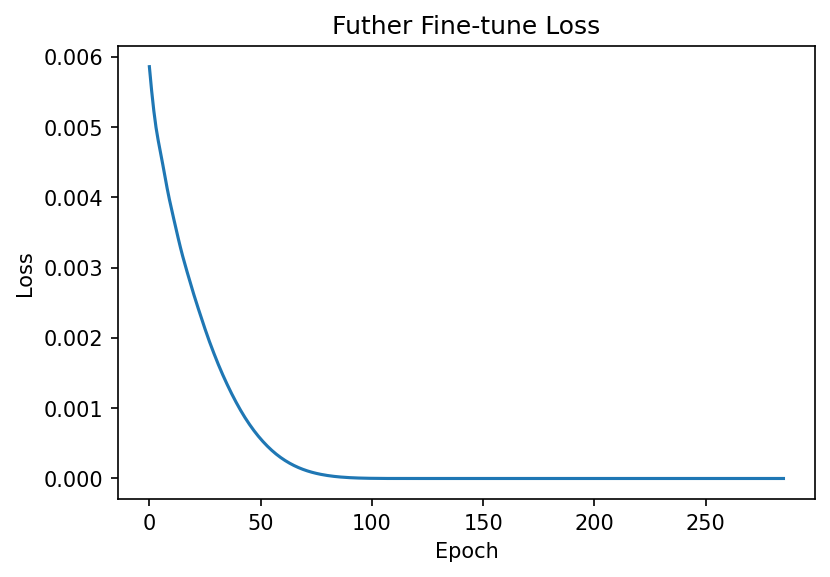

In [17]:
plt.figure(dpi=150)
plt.plot(list(range(len(loss_list))), loss_list)
plt.title("Futher Fine-tune Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.show()

In [18]:
model2 = qml_models.ToffoliQMLNoiseless(final_params.shape[0], final_params.shape[1], final_params.shape[2], res_dict['k'], pool)
print(model2.toList(final_params))

[('CNOT', [0, 2], None), ('CRot', [1, 2], [1.1296803381386924, 1.5707963230898614, -4.693363452215963e-09]), ('CNOT', [0, 2], None), ('CRot', [1, 2], [-1.1930496409647117e-08, -1.5707963411733787, 0.9152925328474281]), ('Rot', [1], [-0.7463000267728153, 1.8594707168136634e-10, 0.7427270843683094]), ('PlaceHolder', [1], None), ('Rot', [0], [-0.7774424773033537, -6.058753607240465e-10, -0.3979643420400851]), ('PlaceHolder', [0], None), ('Rot', [2], [-0.9075802096245182, 5.806605976212192e-09, 0.6860885225524607]), ('PlaceHolder', [2], None), ('PlaceHolder', [0], None), ('PlaceHolder', [1], None), ('PlaceHolder', [2], None), ('PlaceHolder', [2], None), ('PlaceHolder', [0], None)]


In [19]:
@qml.qnode(dev)
def searched_circ(x):
    qml.QubitStateVector(x, wires=[0,1,2])
    qml.CNOT(wires =[0,2])
    qml.CRot(1.1296803381386924, 1.5707963230898614, 0, wires=[1,2])
    qml.CNOT(wires =[0,2])
    qml.CRot(0, -1.5707963411733787, 0.9152925328474281, wires=[1,2])
    qml.Rot(-0.7463000267728153, 0, 0.7427270843683094, wires = 1)
    qml.Rot(-0.7774424773033537, 0, -0.3979643420400851, wires = 0)
    qml.Rot(-0.9075802096245182, 0, 0.6860885225524607, wires = 2)
    return qml.state()

print(qml.draw(searched_circ)(np.kron(computational_bases['1'], np.kron(computational_bases['1'], computational_bases['0']))))

 0: ──╭QubitStateVector(M0)──╭C───────────────────────╭C───Rot(-0.777, 0, -0.398)─────────────────────────╭┤ State 
 1: ──├QubitStateVector(M0)──│───╭C───────────────────│───╭C───────────────────────Rot(-0.746, 0, 0.743)──├┤ State 
 2: ──╰QubitStateVector(M0)──╰X──╰Rot(1.13, 1.57, 0)──╰X──╰Rot(0, -1.57, 0.915)────Rot(-0.908, 0, 0.686)──╰┤ State 
M0 =
[0 0 0 0 0 0 1 0]



In [20]:
for a in computational_bases.keys():
    for b in computational_bases.keys():
        for c in computational_bases.keys():
            state_name = a+b+c
            state = np.kron(np.kron(computational_bases[a], computational_bases[b]), computational_bases[c])
            print("State: ", state_name)
            print("State Vector: ")
            print(state)
            print("Searched Circ Output:")
            print(searched_circ(state))
            print("Target Circ Output:")
            print(target_circ(state))
            print()

State:  000
State Vector: 
[1 0 0 0 0 0 0 0]
Searched Circ Output:
[0.7647+0.6444j 0.    +0.j     0.    +0.j     0.    +0.j     0.    +0.j     0.    +0.j     0.    +0.j     0.    +0.j    ]
Target Circ Output:
[1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]

State:  001
State Vector: 
[0 1 0 0 0 0 0 0]
Searched Circ Output:
[0.    +0.j     0.8876+0.4607j 0.    +0.j     0.    +0.j     0.    +0.j     0.    +0.j     0.    +0.j     0.    +0.j    ]
Target Circ Output:
[0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]

State:  010
State Vector: 
[0 0 1 0 0 0 0 0]
Searched Circ Output:
[ 0.0000e+00+0.0000e+00j  0.0000e+00+0.0000e+00j  9.4739e-01-3.2009e-01j -8.4365e-09-3.2526e-09j  0.0000e+00+0.0000e+00j  0.0000e+00+0.0000e+00j  0.0000e+00+0.0000e+00j  0.0000e+00+0.0000e+00j]
Target Circ Output:
[0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]

State:  011
State Vector: 
[0 0 0 1 0 0 0 0]
Searched Circ Output:
[0.0000e+00+0.0000e+00j 0.0000e+00+0.0000e+00j 6.2744e-09

In [21]:
@qml.qnode(dev)
def searched_circ_stem(x):
    qml.QubitStateVector(x, wires=[0,1,2])
    qml.CNOT(wires =[0,2])
    qml.CRot(1.1296803381386924, 1.5707963230898614, 0, wires=[1,2])
    qml.CNOT(wires =[0,2])
    qml.CRot(0, -1.5707963411733787, 0.9152925328474281, wires=[1,2])
    qml.Rot(-0.7463000267728153, 0, 0.7427270843683094, wires = 1)
    qml.Rot(-0.7774424773033537, 0, -0.3979643420400851, wires = 0)
    qml.Rot(-0.9075802096245182, 0, 0.6860885225524607, wires = 2)
    return qml.state()

compiled_qfunc = qml.compile(
    pipeline=[
        qml.transforms.commute_controlled(direction="left"),
        qml.transforms.merge_rotations(atol=1e-6),
        qml.transforms.cancel_inverses
    ],
    basis_set=["CNOT", "RX", "RY", "RZ"],
    num_passes=200
)(searched_circ_stem)

print(qml.draw(searched_circ_stem)(np.kron(computational_bases['0'], np.kron(computational_bases['1'], computational_bases['0']))))
compiled_qnode = qml.QNode(compiled_qfunc, dev)
print(qml.draw(compiled_qnode)(np.kron(computational_bases['0'], np.kron(computational_bases['1'], computational_bases['0']))))


 0: ──╭QubitStateVector(M0)──╭C───────────────────────╭C───Rot(-0.777, 0, -0.398)─────────────────────────╭┤ State 
 1: ──├QubitStateVector(M0)──│───╭C───────────────────│───╭C───────────────────────Rot(-0.746, 0, 0.743)──├┤ State 
 2: ──╰QubitStateVector(M0)──╰X──╰Rot(1.13, 1.57, 0)──╰X──╰Rot(0, -1.57, 0.915)────Rot(-0.908, 0, 0.686)──╰┤ State 
M0 =
[0 0 1 0 0 0 0 0]

 0: ──RZ(-1.18)──╭C────────────╭C────────────────────╭C────────────────────────────────────────────────────────────╭C────────────────────────────────────────────────────────────────────╭┤ State 
 1: ──RY(1.57)───╰X──RY(1.57)──╰X──RZ(-0.00357)──╭C──│───╭C─────────────╭C──────────────────────────╭C─────────────│───────────────╭C─────────────────────────╭C─────────────────────────├┤ State 
 2: ─────────────────────────────────────────────╰X──╰X──╰X──RZ(0.565)──╰X──RZ(-0.565)──RY(-0.785)──╰X──RY(0.785)──╰X──RZ(-0.458)──╰X──RZ(-0.458)──RY(0.785)──╰X──RY(-0.785)──RZ(0.694)──╰┤ State 

